In [98]:
# Imports
import os , glob
import pandas as pd
import requests
import datetime as dt
import numpy as np
import math
import pandas_montecarlo
from dotenv import load_dotenv
from pathlib import Path
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from scipy.stats import norm
import hvplot.pandas
%matplotlib inline

In [2]:
#Read the FMP API Key
load_dotenv()
#Retrive environment variable and store in Python variable
api_key= os.getenv('FMP_API_KEY')
#confirm retrieval of api key
type(api_key)

str

## Define Variables

In [3]:
crypto_symbol = ['BTCUSD','LTCUSD','ETHUSD','XRPUSD']
url = (f'https://financialmodelingprep.com/api/v3/historical-price-full/crypto/{crypto_symbol}?apikey={api_key}')

In [4]:
def get_crypto_data(cryptourl):
    """
        Returns the crypto data from the specified URL as parameter.

    """
    #get companies based on criteria defined about
    CryptoUSD = requests.get(url)
    CryptoUSD = CryptoUSD.json()    
    CryptoUSD = CryptoUSD['historical']
    Crypto = pd.DataFrame.from_dict(CryptoUSD)
    #Crypto['date'] = pd.to_datetime(Crypto['date'])
    Crypto.set_index('date',inplace=True)    
    #Keep only the close column- Open, close, adjclose, volume,chanepercent
    columns =['change','high','label','low','unadjustedVolume','vwap','changeOverTime','close']
    Crypto= Crypto.drop(columns, axis=1)    
    #Rename the column adjclose and changepercent to close and percentchange
    Crypto.rename(columns = {'adjClose' : 'close' , 'changePercent' : 'change%'}, inplace = True)
    return Crypto

In [5]:
def saveto_csv(dataFrame,fileName):    
    newfilename= "Data\\"  + fileName +".csv"    
    dataFrame.to_csv(newfilename,index = True)

In [6]:
def convert_daily_to_monthly(df):
    #Resample dataframe in order to get monthly prices     
    df.index = pd.to_datetime(df.index)
    df=df.resample('M').mean()
    return df

In [7]:
def combine_data(csvFilelist,outputfile):
    i = len(csvFilelist)
    for file in csvFilelist:
        # read first file
        file1 = pd.read_csv("Data\\"+file)
        #read second file
        file2 = pd.read_csv(csvFile2)
        concate_data = pd.concat([file1,file2],index=date)
        concate_data.head()
        print("merged data file",merged_data.head())
    return merged_data  

In [8]:
for symbol in crypto_symbol:
    url = (f'https://financialmodelingprep.com/api/v3/historical-price-full/crypto/{symbol}?apikey={api_key}')
    crypto_df= get_crypto_data(url)
    saveto_csv(crypto_df,symbol)

## Calculate returns of crypto data weightage is 0.02

In [9]:
def get_crypto_returns(csvFile):   
    # set the file path
    file_path = Path(csvFile)
    # create a Pandas DataFrame from a csv file
    df = pd.read_csv(file_path)   
    # drop null values
    df = df.dropna().copy()   
    #set date as index
    df = df.set_index("date")
    # drop all columns except close
    columns =['open','volume']
    df = df.drop(columns, axis=1)
    #rename column
    columnname = symbol[:-3]
    df.rename(columns = {'close' : columnname}, inplace = True)  
    df.rename(columns = {'change%' : columnname+'_change%'}, inplace = True) 
    return df    

In [10]:
for symbol in crypto_symbol: 
    csvFile = 'Data\\'+symbol+'.csv'
    if symbol == 'BTCUSD':
        btc_df=get_crypto_returns(csvFile)       
    elif symbol == 'LTCUSD':
        ltc_df=get_crypto_returns(csvFile)
    elif symbol == 'XRPUSD':
        xrp_df=get_crypto_returns(csvFile)
    elif symbol == 'ETHUSD':
        etc_df=get_crypto_returns(csvFile)    

combine_crypto_df = pd.concat([btc_df,ltc_df,xrp_df,etc_df], axis = 'columns', join='inner')
saveto_csv(combine_crypto_df,'daily_cryptoall')
monthly_crypto_df=convert_daily_to_monthly(combine_crypto_df)
saveto_csv(monthly_crypto_df,'monthly_cryptoall')

In [11]:
csvFilelist=['daily_cryptoall.csv','daily_commodity_df.csv','daily_sp500_returns.csv','daily_bond_data.csv']
i = len(csvFilelist)
for file in csvFilelist:
    if file.startswith('daily_crypto'):
        file1 = pd.read_csv("Data\\"+file, parse_dates=True, infer_datetime_format=True)
        file1=file1.set_index('date')
    elif file.startswith('daily_sp500'):
        #read second file    
        file2 = pd.read_csv("Data\\"+file,parse_dates=True, infer_datetime_format=True)         
        file2=file2.set_index('date')
        file2.rename(columns = {'close' : 'sp500_close','change%' :'sp500_change%'}, inplace = True)        
    elif file.startswith('daily_commodity'):
        file3 = pd.read_csv("Data\\"+file, parse_dates=True, infer_datetime_format=True)
        # rename Pandas columns to lower case        
        file3.columns= file3.columns.str.lower()
        file3 = file3.drop(['open','low','high','volume','open.1','low.1','high.1','volume.1'],axis=1)
        file3['date'] = pd.to_datetime(file3['date'], format="%d/%m/%Y")                      
        file3=file3.set_index('date')       
    else:
        file4=pd.read_csv("Data\\"+file,parse_dates=True, infer_datetime_format=True)                
        file4.columns= file4.columns.str.lower()     
        file4['5 yr'] = file4['5 yr'] / 100
        file4=file4.set_index('date')        
        file4.rename(columns = {'5 yr' : 'bonds5yr_close'}, inplace = True)           
    

concate_data = pd.merge(file1,file2, on='date', how='inner')
merged_df = concate_data.join(file3, how='inner')
final_merged_df = merged_df.join(file4, how='inner')
saveto_csv(final_merged_df,'daily_combineall')     

In [12]:
csvFilelist=['monthly_cryptoall.csv','monthly_commodity_df.csv','monthly_sp500_returns.csv','monthly_bonds_data.csv']
i = len(csvFilelist)
for file in csvFilelist:
    if file.startswith('monthly_crypto'):
        file1 = pd.read_csv("Data\\"+file, parse_dates=True, infer_datetime_format=True)
        file1=file1.set_index('date')
    elif file.startswith('monthly_sp500'):
        #read second file    
        file2 = pd.read_csv("Data\\"+file, parse_dates=True, infer_datetime_format=False)               
        file2 = file2.drop(['open','volume'],axis=1)
        file2.rename(columns = {'close' : 'sp500_close', 'change%' : 'sp500_change%'}, inplace = True)
        file2=file2.set_index('date')
    elif file.startswith('monthly_commodity'):
        file3 = pd.read_csv("Data\\"+file, parse_dates=True, infer_datetime_format=True)
        # rename Pandas columns to lower case        
        file3.columns= file3.columns.str.lower()
        file3 = file3.drop(['open','low','high','open.1','low.1','high.1'],axis=1)
        #file3['date'] = pd.to_datetime(file3['date'], format="%d/%m/%Y")   
        file3=file3.set_index('date')
    else:
        file4=pd.read_csv("Data\\"+file,parse_dates=True, infer_datetime_format=True)
        file4.columns= file4.columns.str.lower()
        file4=file4.set_index('date')
        file4.rename(columns = {'rate' : 'bonds_close'}, inplace = True)    
    

concate_monthly = pd.concat([file1,file2,file3,file4],axis='columns', join='inner')
saveto_csv(concate_monthly,'monthly_combineall')     

## Calcualte Standard deviation of daily files

In [227]:
def calculate_standard_dev(fileName):
    # Read file 
    portfolio_data = Path(fileName)
    portfolio_df = pd.read_csv(portfolio_data, index_col="date", infer_datetime_format=True, parse_dates=True)

    # Sorting the date index in ascending order
    portfolio_df = portfolio_df.sort_index()
    
    # Remove close price columns
    columns=['BTC_change%','LTC_change%','XRP_change%','ETH_change%','sp500_change%','gold_rate%','silver_rate%']
    portfolio_df= portfolio_df.drop(columns, axis=1)
    #rename columns
    portfolio_df.rename(columns = {'bonds5yr_close':'bonds','silver_close':'silver','sp500_close':'sp500','gold_close':'gold'},inplace=True)
    portfolio_df=portfolio_df.sort_values(by='date',ascending=True)
    #calculate daily returns
    #daily_returns = portfolio_df.pct_change().dropna().copy()
           
    # columns wise Daily Standard Deviations of all portfolio
    #daily_std=portfolio_df.std(axis=0)  
    # columns wise Daily Standard Deviations of all portfolio
    daily_std=portfolio_df.std(axis=0)
    print(daily_std.index)
    print(daily_std.values)
    assets_std = daily_std.hvplot(  
                                 xlabel=" Assests ", 
                                 ylabel="Assests Standard Deviation Value", 
                                 title = 'Standard Deviation',
                                 kind='line',
                                 width=400, 
                                 height=300
                            ).opts(axiswise=True)    
    return assets_std

In [228]:
calculate_standard_dev('Data/daily_combineall.csv')
#stdev.plot()

Index(['BTC', 'LTC', 'XRP', 'ETH', 'sp500', 'silver', 'gold', 'bonds'], dtype='object')
[3.91145995e+03 5.53772140e+01 3.28514331e-01 2.27820753e+02
 3.60894499e+02 1.53567854e+00 1.58247505e+02 7.07551373e-03]


:Curve   [index]   (0)

In [224]:
def calculate_sharpe_ratio(fileName):
    # Read file 
    portfolio_data = Path(fileName)
    portfolio_df = pd.read_csv(portfolio_data, index_col="date", infer_datetime_format=True, parse_dates=True)

    # Sorting the date index in ascending order
    portfolio_df = portfolio_df.sort_index()
    
    # Remove %change columns
    columns=['BTC_change%','LTC_change%','XRP_change%','ETH_change%','sp500_change%','gold_rate%','silver_rate%']
    portfolio_df= portfolio_df.drop(columns, axis=1)
    
    #rename columns
    portfolio_df.rename(columns = {'bonds5yr_close':'bonds','silver_close':'silver','sp500_close':'sp500','gold_close':'gold'},inplace=True)   
    
    # Daily Returns
    daily_returns = portfolio_df.pct_change().dropna().copy()
     
    # Calculate sharpe ratio
    sharpe_ratios = (daily_returns.mean() * 252) / (daily_returns.std() * np.sqrt(252))
      
    return sharpe_ratios.hvplot(line_color='green',ylabel='Sharpe Ratio', xlabel = 'Assets', legend=False, width=400, height=400,title="Sharpe Ratio",invert=True)
#sharpe_ratios.hvplot(linecolor='lightgray', y=['BTC','LTC','XRP','ETH','gold','sp500','silver','bonds'], value_label='Asessts' , length='top', height=500, width=620)

In [225]:
calculate_sharpe_ratio('Data/daily_combineall.csv')

:Curve   [index]   (0)

# Beta Calcuation

C:\Users\Purvi\anaconda3\envs\pyvizenv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



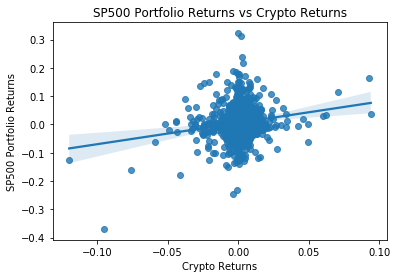

In [179]:
# Read file 
portfolio_data = Path('Data/daily_combineall.csv')
portfolio_df = pd.read_csv(portfolio_data, index_col="date", infer_datetime_format=True, parse_dates=True)

# Sorting the date index in ascending order
portfolio_df = portfolio_df.sort_index()
    
# Remove close price columns
columns=['BTC_change%','LTC_change%','XRP_change%','ETH_change%','sp500_change%','gold_rate%','silver_rate%']
portfolio_df= portfolio_df.drop(columns, axis=1)
#rename columns
portfolio_df.rename(columns = {'bonds5yr_close':'bonds','silver_close':'silver','sp500_close':'sp500','gold_close':'gold'},inplace=True)
portfolio_df=portfolio_df.sort_values(by='date',ascending=True)
# Create a list of tickers and weights
fig, ax = plt.subplots() 
wts = [0.25,0.25,0.25,0.25]
df_crypto = portfolio_df[['BTC','LTC','XRP','ETH']]
crpt_data = df_crypto.pct_change()[1:]
crypto = (crpt_data * wts).sum(axis = 1)
sp500 = portfolio_df["sp500"].pct_change()[1:]
df_bonds=portfolio_df[['bonds']]
bdata = df_bonds.pct_change()[1:]
sns.regplot(sp500.values,crypto.values)
plt.xlabel("Crypto Returns")
plt.ylabel("SP500 Portfolio Returns")
plt.title("SP500 Portfolio Returns vs Crypto Returns")
plt.show()
fig.savefig('BetaCaluation.png')

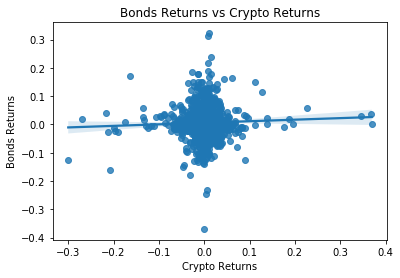

In [171]:
fig, ax = plt.subplots() 
sns.regplot(bdata.values,crypto.values)
plt.xlabel("Crypto Returns")
plt.ylabel("Bonds Returns")
plt.title("Bonds Returns vs Crypto Returns")
plt.show()
fig.savefig('BetaCaluationCryptovsbonds.png')

# Risk Calculation

In [181]:
def risk_calculation(symbol,risk_weights,df):    
    df[symbol] = df.dot(risk_weights)
    df.plot(figsize=(20,10), title='Assests Daily Returns for'+ symbol)
    #df.iplot(mode = "markers", size = 5)

In [91]:
def combine_assets_dailyvalue():
    #read the daily comibneall file
    daily_data = Path("Data/daily_combineall.csv")
    daily_df = pd.read_csv(daily_data, index_col="date", infer_datetime_format=True, parse_dates=True)
    
    daily_df1 = daily_df[['BTC','LTC','XRP','ETH', 'sp500_close', 'silver_close', 'gold_close','bonds5yr_close']]
    daily_df1 = daily_df1.pct_change().dropna()
    #daily_df1 = pd.concat([daily_df1, daily_df2], axis="columns", join="inner")

    #extrat sp500 and bonds data from daily file
    sandp_bonds_return = daily_df1[['bonds5yr_close', 'sp500_close']]
    sandp_bonds_return = sandp_bonds_return.dropna().copy()
    #extract commodity value from the daily file
    join_cmod_df = daily_df[['silver_close', 'gold_close']]
    cmod_returns = join_cmod_df.pct_change()
    cmod_returns = cmod_returns.dropna().copy()
    # calculate % change of commodity
    weights = [0.50, 0.50]
    cmod_returns['cmod_change%'] = cmod_returns.dot(weights)
    cmod_returns = cmod_returns[['cmod_change%']]
    #combine crypto currency coins as one assest
    join_crypto_df = daily_df[['BTC', 'LTC', 'XRP', 'ETH']]
    crypto_returns = join_crypto_df.pct_change()
    crypto_returns = crypto_returns.dropna().copy()
    #calculate crypto %change 
    weights = [0.20, 0.20, 0.20, 0.20]
    crypto_returns['crypto_change%'] = crypto_returns.dot(weights)
    crypto_change = crypto_returns[['crypto_change%']]
    # combine all the returns in one dataframe
    all_returns = pd.concat([sandp_bonds_return, crypto_change, cmod_returns], axis="columns", join="inner")
    all_returns = all_returns.sort_index()    
    all_returns.columns = ['Bonds Change %', 'S&P 500 Change %', 'Crypto Change %', 'Commodity Change %']
    return all_returns

C:\Users\Purvi\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\figure.py:445: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



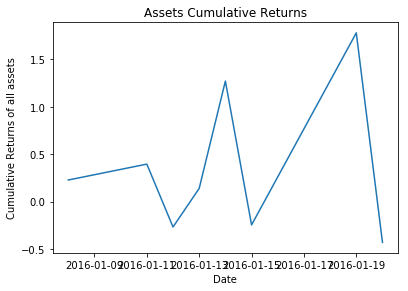

In [209]:
portfolio_df=combine_assets_dailyvalue()
daily_returns = portfolio_df.pct_change()[1:]
weights_risk_averse = [0.5,0.3,0.05,0.15]
#weights_risk_neutral = [0.2,0.5,0.1,0.2]
#weights_risk_high = [0.05,0.5,0.30,0.15]
weighted_returns = (weights_risk_averse * daily_returns)
port_ret = weighted_returns.sum(axis=1)
cumulative_ret = (port_ret + 1).cumprod()
#print(cumulative_ret.head())
#cumulative_ret.hvplot()
fig =plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(cumulative_ret)
ax1.set_xlabel('Date')
ax1.set_ylabel("Cumulative Returns of all assets")
ax1.set_title("Assets Cumulative Returns")
plt.show()
fig.savefig('Images\RiskAverse_return.jpg') 

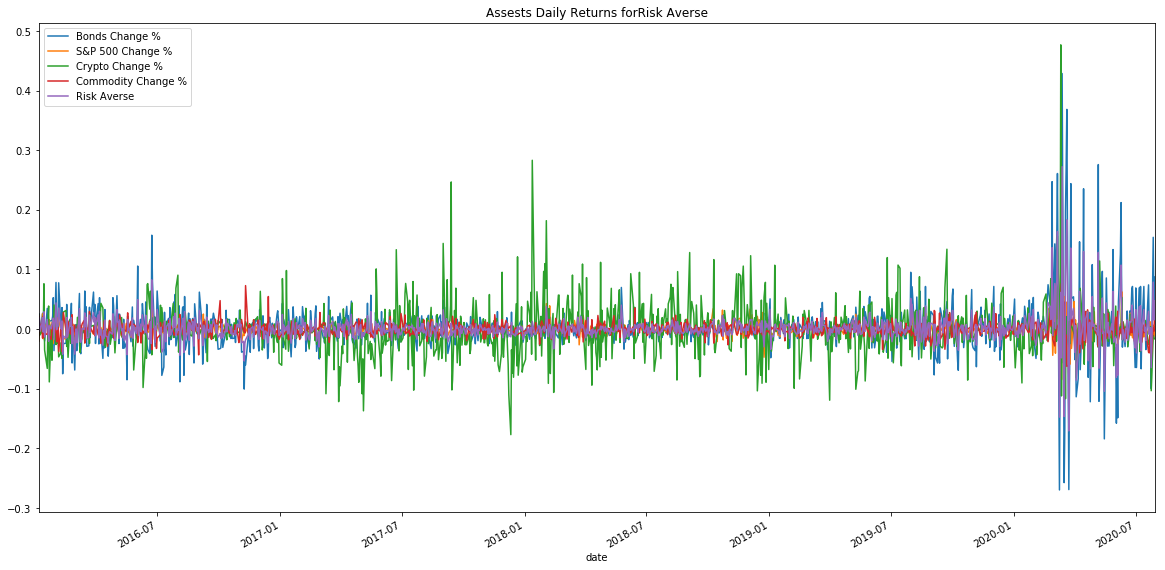

In [183]:
daily_returns_assets=combine_assets_dailyvalue()
weights_risk_averse = [0.5,0.3,0.05,0.15]
risk_calculation('Risk Averse',weights_risk_averse,daily_returns_assets)

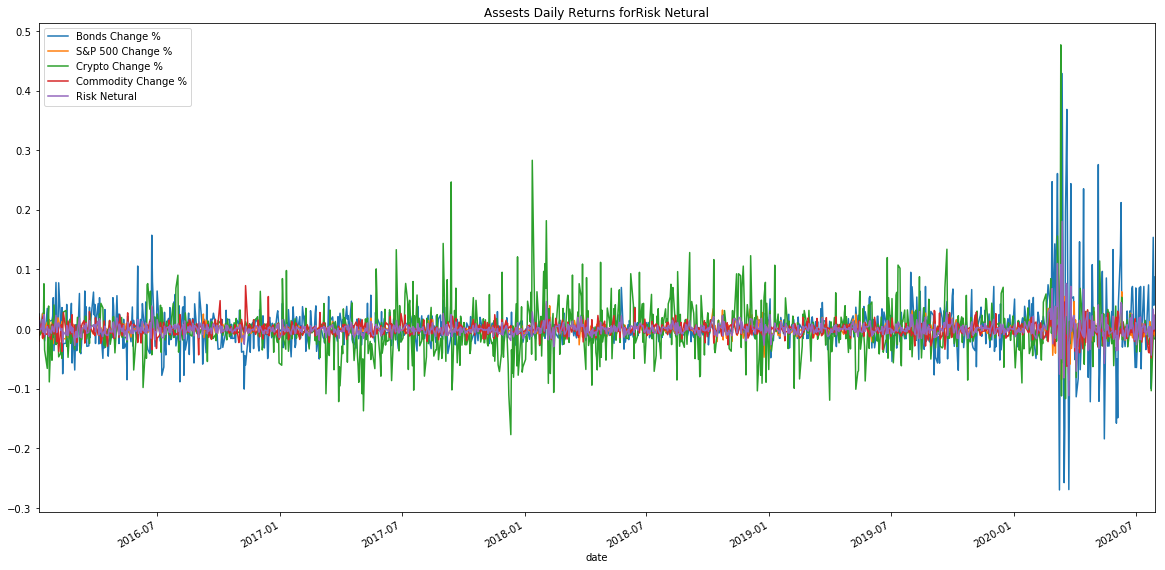

In [121]:
daily_returns_assets=daily_returns_assets.drop(columns = ['Risk Averse'], axis = 1)
weights_risk_neutral = [0.2,0.5,0.1,0.2,0]
risk_calculation('Risk Netural',weights_risk_neutral,daily_returns_assets)

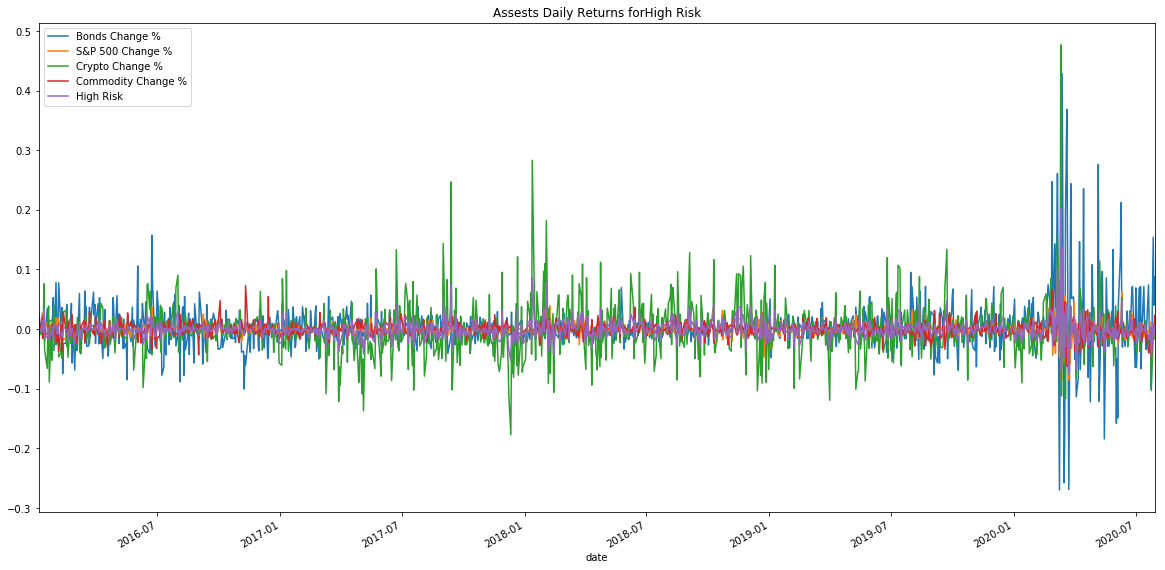

In [131]:
daily_returns_assets=daily_returns_assets.drop(columns = ['Risk Netural'], axis = 1)
weights_risk_high = [0.05,0.5,0.30,0.15]
risk_calculation('High Risk', weights_risk_high,daily_returns_assets)

In [206]:
def monte_carlo_simulation(df,num_simulation,num_days):  
    fig =plt.figure()
    #set up empty list to hold our ending values for each simulated price series
    result = []
    #Define Variables
    S = df['sp500_close'][-1] #starting stock price (i.e. last available real stock price)    
    T = 252 #Number of trading days
    mu = 0.2309 #Return
    vol = 0.4259 #Volatility
    #choose number of runs to simulate - I have chosen 10,000
    for i in range(500):
        #create list of daily returns using random normal distribution
        daily_returns=np.random.normal(mu/T,vol/math.sqrt(T),T)+1
    
        #set starting price and create price series generated by above random daily returns
        price_list = [S]
    
        for x in daily_returns:
            price_list.append(price_list[-1]*x)
            #plot data from each individual run which we will plot at the end
        plt.plot(price_list)
    
        #append the ending value of each simulated run to the empty list we created at the beginning
        result.append(price_list[-1])
    #show the plot of multiple price series created above
    fig.show()
    plt.title("SP500 Montecarlo Simulation")
    plt.figure(figsize=(30, 30))
    plt.show()
    fig.savefig('Montecarlo_Simulation.jpg')
    #create histogram of ending stock values for our mutliple simulations
    #plt.hist(result,bins=50)
    #plt.show()

C:\Users\Purvi\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\figure.py:445: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



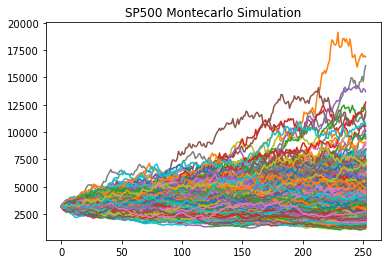

<Figure size 2160x2160 with 0 Axes>

In [207]:
import pandas_montecarlo
daily_data = Path("Data/monthly_combineall.csv")
daily_df = pd.read_csv(daily_data, index_col="date", infer_datetime_format=True, parse_dates=True)    
daily_df1 = daily_df[['BTC','LTC','XRP','ETH', 'sp500_close', 'silver_close', 'gold_close']]
monte_carlo_simulation(daily_df1,500,252)

#daily_df.hvplot(x='date', y=['BTC','LTC','XRP','ETH','sp500_close','gold_close', 'silver_close', 'BTC_change%','LTC_change%','XRP_change%','ETH_change%','sp500_change%','monthly_gold_%', 'monthly_silver_%'], 
#                width=300, height=200, subplots=True, shared_axes=False).cols(7)

:NdOverlay   [Variable]
   :Curve   [date]   (Assets Daily Close Price)

In [229]:
def read_data():
    # Read file 
    portfolio_data = Path('Data/daily_combineall.csv')
    portfolio_df = pd.read_csv(portfolio_data, index_col="date", infer_datetime_format=True, parse_dates=True)

    # Sorting the date index in ascending order
    portfolio_df = portfolio_df.sort_index()
    
    # Remove close price columns
    columns=['BTC_change%','LTC_change%','XRP_change%','ETH_change%','sp500_change%','gold_rate%','silver_rate%']
    portfolio_df= portfolio_df.drop(columns, axis=1)
    
    #rename columns
    portfolio_df.rename(columns = {'bonds5yr_close':'bonds','silver_close':'silver','sp500_close':'sp500','gold_close':'gold'},inplace=True)
    portfolio_df=portfolio_df.sort_values(by='date',ascending=True)  
    return portfolio_df

In [230]:
def calculate_sharpe_ratio():
    df_data = read_data()    
    # Daily Returns
    daily_return = df_data.pct_change().dropna().copy()
   
    # Calculate sharpe ratio
    sharpe_ratios = (daily_return.mean() * 252) / (daily_return.std() * np.sqrt(252))
    return sharpe_ratios.hvplot(line_color='green',ylabel='Sharpe Ratio', xlabel = 'Assets',title="Sharpe Ratio of Assests", legend=False, width=400, height=300, invert=True)       
    

In [231]:
calculate_sharpe_ratio()

:Curve   [index]   (0)